In [1]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_len, output_len = 20, 10

In [3]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, input_len, output_len, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=True)
# features = getFeatures()

In [4]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 13])
torch.Size([64, 10])


In [5]:
# build TCN-LSTM model

class Encoder(nn.Module):
    def __init__(self, input_size, seq_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2):
        super(Encoder, self).__init__()
        self.tcn = TemporalConvNet(input_size, tcn_num_channels, tcn_kernel_size, tcn_dropout)
        self.fc_feature = nn.Linear(tcn_num_channels[-1], lstm_num_hidden)
        self.fc_time = nn.Linear(seq_len, 1)
        self.lstm_num_hidden = lstm_num_hidden
    
    def forward(self, x):
        output = self.tcn(x.transpose(1, 2)) # (batch_size, tcn_num_channels[-1], seq_len)
        output = output.transpose(1, 2) # (batch_size, seq_len, tcn_num_channels[-1])
        output = self.fc_feature(output) # (batch_size, seq_len, lstm_num_hidden)

        h = output[:, -1, :] # (batch_size, lstm_num_hidden)

        c = output.transpose(1, 2) # (batch_size, lstm_num_hidden, seq_len)
        c = self.fc_time(c).squeeze(2) # (batch_size, lstm_num_hidden)
        return h, c


class Decoder(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.num_layers = num_layers
        self.seq_len = seq_len

    def forward(self, x, hidden, cell):
        # repeat the hidden states according to the number of layers
        hidden = hidden.repeat(self.num_layers, 1, 1)
        cell = cell.repeat(self.num_layers, 1, 1)
        outputs = []
        for t in range(self.seq_len):
            xt = x[:, t, :].unsqueeze(1)
            output, (hidden, cell) = self.lstm(xt, (hidden, cell))
            output = self.fc(output) 
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs


class TCN_LSTM(nn.Module):
    def __init__(self, input_size, input_len, output_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size=2, tcn_dropout=0.2, num_layers=1):
        super(TCN_LSTM, self).__init__()
        self.encoder = Encoder(input_size, input_len, tcn_num_channels, lstm_num_hidden, tcn_kernel_size, tcn_dropout)
        self.decoder = Decoder(input_size, output_len, lstm_num_hidden, num_layers)

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        h, c = self.encoder(x)
        outputs = self.decoder(xt, h, c) # (batch_size, output_len, 1)
        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
input_len = 20
output_len = 10
hidden_size = 32  
num_layers = 1


# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = TCN_LSTM(input_size, input_len, output_len, [32, 32], hidden_size, num_layers=num_layers).to(device)

cuda


In [ ]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 25
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        with torch.no_grad():
            outputs = seq2seq(inputs)  
            outputs = outputs.squeeze(-1) # (batch_size, output_len)
            loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt')


Epoch 1/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 80.03it/s, train_loss=7.77e-5]


Epoch 1/25, Average Training Loss: 0.005139


Epoch 1/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.98it/s, val_loss=0.0054] 


Epoch 1/25, Average Validation Loss: 0.004660


Epoch 2/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.54it/s, train_loss=0.00533]


Epoch 2/25, Average Training Loss: 0.003898


Epoch 2/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 115.74it/s, val_loss=0.00423]


Epoch 2/25, Average Validation Loss: 0.004059


Epoch 3/25 [TRAIN]: 100%|██████████| 2296/2296 [00:29<00:00, 76.84it/s, train_loss=1.68e-5]


Epoch 3/25, Average Training Loss: 0.003633


Epoch 3/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.83it/s, val_loss=0.00491]


Epoch 3/25, Average Validation Loss: 0.003660


Epoch 4/25 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 85.47it/s, train_loss=0.00159]


Epoch 4/25, Average Training Loss: 0.003482


Epoch 4/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 119.09it/s, val_loss=0.00428]


Epoch 4/25, Average Validation Loss: 0.003318


Epoch 5/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 80.73it/s, train_loss=0.000626]


Epoch 5/25, Average Training Loss: 0.003373


Epoch 5/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.07it/s, val_loss=0.00408]


Epoch 5/25, Average Validation Loss: 0.003180


Epoch 6/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.05it/s, train_loss=0.0116] 


Epoch 6/25, Average Training Loss: 0.003275


Epoch 6/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.27it/s, val_loss=0.00485]


Epoch 6/25, Average Validation Loss: 0.003357


Epoch 7/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.99it/s, train_loss=0.00112]


Epoch 7/25, Average Training Loss: 0.003197


Epoch 7/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.97it/s, val_loss=0.00422]


Epoch 7/25, Average Validation Loss: 0.003051


Epoch 8/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.11it/s, train_loss=0.0053] 


Epoch 8/25, Average Training Loss: 0.003129


Epoch 8/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.25it/s, val_loss=0.00454]


Epoch 8/25, Average Validation Loss: 0.003081


Epoch 9/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.15it/s, train_loss=0.00327]


Epoch 9/25, Average Training Loss: 0.003068


Epoch 9/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 116.52it/s, val_loss=0.00537]


Epoch 9/25, Average Validation Loss: 0.003448


Epoch 10/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.55it/s, train_loss=0.00473]


Epoch 10/25, Average Training Loss: 0.003027


Epoch 10/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.67it/s, val_loss=0.00422]


Epoch 10/25, Average Validation Loss: 0.002894


Epoch 11/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.98it/s, train_loss=0.000775]


Epoch 11/25, Average Training Loss: 0.002985


Epoch 11/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.19it/s, val_loss=0.00419]


Epoch 11/25, Average Validation Loss: 0.002925


Epoch 12/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.00it/s, train_loss=0.00414]


Epoch 12/25, Average Training Loss: 0.002954


Epoch 12/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 113.20it/s, val_loss=0.00433]


Epoch 12/25, Average Validation Loss: 0.002919


Epoch 13/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 80.36it/s, train_loss=0.0101] 


Epoch 13/25, Average Training Loss: 0.002942


Epoch 13/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.41it/s, val_loss=0.00446]


Epoch 13/25, Average Validation Loss: 0.002900


Epoch 14/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.80it/s, train_loss=0.00204]


Epoch 14/25, Average Training Loss: 0.002899


Epoch 14/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 115.70it/s, val_loss=0.00391]


Epoch 14/25, Average Validation Loss: 0.002794


Epoch 15/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.38it/s, train_loss=0.000647]


Epoch 15/25, Average Training Loss: 0.002864


Epoch 15/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.49it/s, val_loss=0.00401]


Epoch 15/25, Average Validation Loss: 0.002833


Epoch 16/25 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 79.92it/s, train_loss=9.14e-6]


Epoch 16/25, Average Training Loss: 0.002851


Epoch 16/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 115.80it/s, val_loss=0.00376]


Epoch 16/25, Average Validation Loss: 0.002869


Epoch 17/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.21it/s, train_loss=0.00139]


Epoch 17/25, Average Training Loss: 0.002845


Epoch 17/25 [VAL]: 100%|██████████| 769/769 [00:07<00:00, 105.58it/s, val_loss=0.00406]


Epoch 17/25, Average Validation Loss: 0.002799


Epoch 18/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.12it/s, train_loss=1.2e-5] 


Epoch 18/25, Average Training Loss: 0.002818


Epoch 18/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.55it/s, val_loss=0.00395]


Epoch 18/25, Average Validation Loss: 0.002758


Epoch 19/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.36it/s, train_loss=1.98e-5]


Epoch 19/25, Average Training Loss: 0.002802


Epoch 19/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.68it/s, val_loss=0.00376]


Epoch 19/25, Average Validation Loss: 0.002794


Epoch 20/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.09it/s, train_loss=0.00038]


Epoch 20/25, Average Training Loss: 0.002769


Epoch 20/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.27it/s, val_loss=0.00384]


Epoch 20/25, Average Validation Loss: 0.002730


Epoch 21/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.14it/s, train_loss=0.000415]


Epoch 21/25, Average Training Loss: 0.002765


Epoch 21/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.36it/s, val_loss=0.00372]


Epoch 21/25, Average Validation Loss: 0.002758


Epoch 22/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.85it/s, train_loss=0.00213]


Epoch 22/25, Average Training Loss: 0.002753


Epoch 22/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.31it/s, val_loss=0.00408]


Epoch 22/25, Average Validation Loss: 0.002732


Epoch 23/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 82.66it/s, train_loss=0.00073]


Epoch 23/25, Average Training Loss: 0.002724


Epoch 23/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 116.99it/s, val_loss=0.00402]


Epoch 23/25, Average Validation Loss: 0.002696


Epoch 24/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.28it/s, train_loss=0.0014] 


Epoch 24/25, Average Training Loss: 0.002737


Epoch 24/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 117.20it/s, val_loss=0.00399]


Epoch 24/25, Average Validation Loss: 0.002779


Epoch 25/25 [TRAIN]: 100%|██████████| 2296/2296 [00:27<00:00, 83.24it/s, train_loss=0.000541]


Epoch 25/25, Average Training Loss: 0.002707


Epoch 25/25 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 118.26it/s, val_loss=0.00412]

Epoch 25/25, Average Validation Loss: 0.002686


Test loss: 0.001977746607735753
MAPE: 18.198366165161133


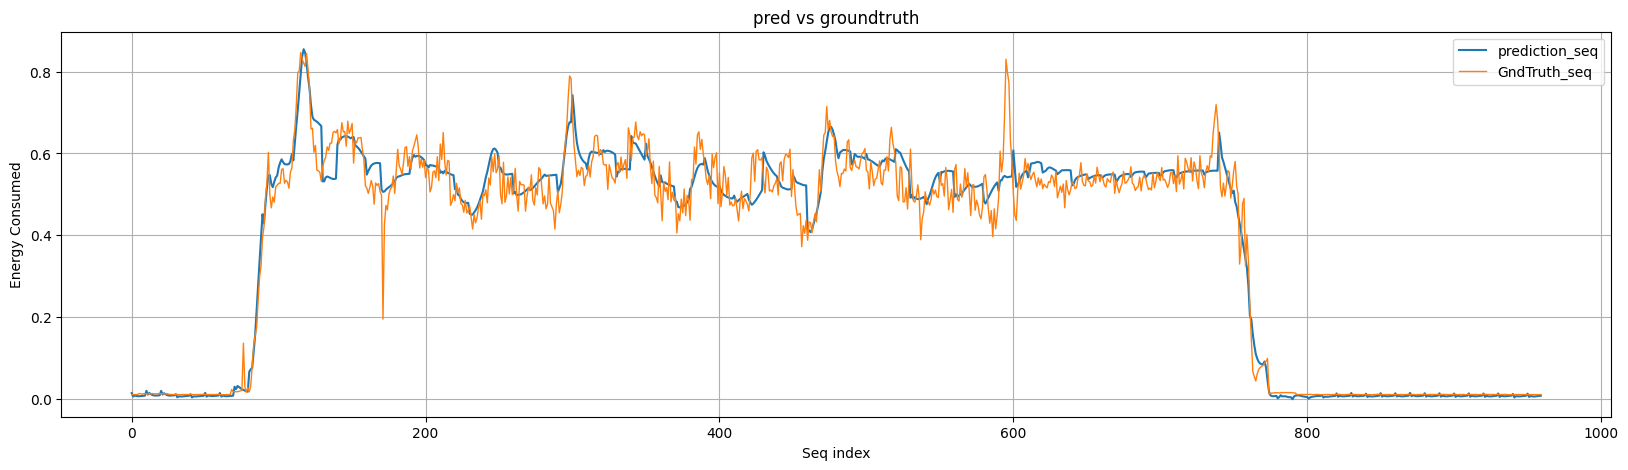

In [ ]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values,input_len,output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [ ]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'TCN_LSTM_select2_covariate_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
test_nums = d_split['test']
test_nums.remove(273)

for f_num in d_split['test']:
    test_data = data[data['flight'] == f_num]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                            test_data['power'].values,input_len,output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

    print(f"Flight {f_num}:")

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq
    
        error = nn.MSELoss()(outputs, targets)
        print(f"Test loss: {error}")

        mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
        print(f"MAPE: {mape}")

Flight 3:
Test loss: 0.00325374654494226
MAPE: 13.634073257446289
Flight 124:
Test loss: 0.0031392835080623627
MAPE: 20.190614700317383
Flight 16:
Test loss: 0.002627571579068899
MAPE: 13.3700590133667
Flight 261:
Test loss: 0.0019418367883190513
MAPE: 13.974924087524414
Flight 152:
Test loss: 0.002490247366949916
MAPE: 13.524629592895508
Flight 94:
Test loss: 0.0017075826181098819
MAPE: 12.101998329162598
Flight 254:
Test loss: 0.0027327442076057196
MAPE: 18.317338943481445
Flight 262:
Test loss: 0.0018145438516512513
MAPE: 15.482550621032715
Flight 135:
Test loss: 0.002422562101855874
MAPE: 12.376923561096191
Flight 17:
Test loss: 0.002881780732423067
MAPE: 11.576759338378906
Flight 232:
Test loss: 0.003403622889891267
MAPE: 16.006500244140625
Flight 20:
Test loss: 0.0030598242301493883
MAPE: 10.158626556396484
Flight 243:
Test loss: 0.0014333147555589676
MAPE: 16.491846084594727
Flight 113:
Test loss: 0.003838624805212021
MAPE: 16.631816864013672
Flight 246:
Test loss: 0.00145307474

In [ ]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 16.816220599719998


It seems LSTM-LSTM is better than current design of TCN-LSTM